In [12]:
from pdb import set_trace

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Vanishing Gradients

## Introduction
This notebook explains the concepts of **vanishing gradients** and **exploding gradients**, demonstrates them using examples, and provides solutions to handle them both in vanilla Python and PyTorch.

### What are Vanishing and Exploding Gradients?
- **Vanishing Gradients**: Gradients become very small during backpropagation, leading to slow or halted learning, especially in deep networks with sigmoid or tanh activations.
- **Exploding Gradients**: Gradients grow excessively, making the training unstable, often due to poor initialization or high learning rates.

In [1]:
import math
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Demonstrating Vanishing Gradients

Here, we create a deep neural network with sigmoid activation functions to observe the vanishing gradients problem.

In [13]:
def return_data():
    iris = load_iris()
    X = iris.data
    y = iris.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    x_train = torch.FloatTensor(X_train_scaled)
    y_train = torch.LongTensor(y_train)
    
    return x_train, y_train

In [14]:
x,y = return_data()

In [15]:
class SigmoidNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 32),
            nn.Sigmoid(),
            nn.Linear(32, 32),
            nn.Sigmoid(),
            nn.Linear(32, 32),
            nn.Sigmoid(),
            nn.Linear(32, 32),
            nn.Sigmoid(),
            nn.Linear(32, 16),
            nn.Sigmoid(),
            nn.Linear(16, 8),
            nn.Sigmoid(),
            nn.Linear(8, 3),
        )
    
    def forward(self, x):
        return self.layers(x)

In [16]:
sig_mdl = SigmoidNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(sig_mdl.parameters(), lr=0.1)

In [17]:
def train_and_return_grads(mdl):
    '''
    returns mdl, grads, loss_gaps
    '''
    grads = []
    loss_gaps = 0
    for epoch in range(500):
        optimizer.zero_grad()
        output = mdl(x)
        loss = criterion(output, y)
        loss.backward()
        grads.append(mdl.layers[0].weight.grad.norm().item())
        optimizer.step()
        
        if epoch == 0:
            loss_gaps = loss
        
        if epoch % 100 == 0:
            print(loss)
            
        if epoch == 499:
            loss_gaps = loss - loss_gaps
        
    return mdl, grads, loss_gaps.item()

In [18]:
mdl, sigmoid_grads, sig_loss_gaps = train_and_return_grads(sig_mdl)

tensor(1.1404, grad_fn=<NllLossBackward0>)
tensor(1.0984, grad_fn=<NllLossBackward0>)
tensor(1.0984, grad_fn=<NllLossBackward0>)
tensor(1.0984, grad_fn=<NllLossBackward0>)
tensor(1.0984, grad_fn=<NllLossBackward0>)


In [19]:
sig_loss_gaps

-0.04203641414642334

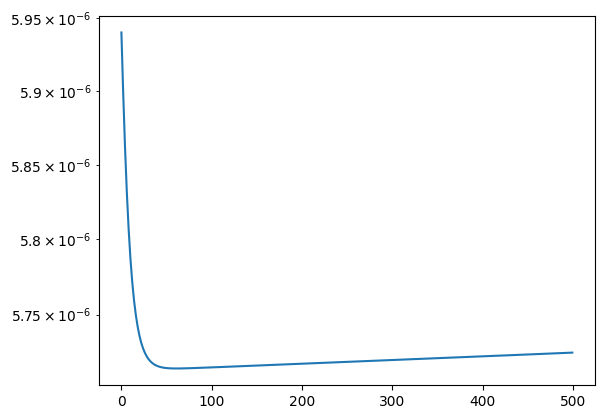

In [20]:
plt.yscale("log") 
plt.plot(sigmoid_grads)

In [10]:
sum(sigmoid_grads) / len(sigmoid_grads)

4.553330883936724e-06

In [21]:
def calc_acc(mdl):
    score = 0
    for idx, tensor in enumerate(mdl(x)):
        res = tensor.argmax()
        if res == y[idx]:
            score +=1
    avg_score = score / len(x)
    return avg_score

In [41]:
nn.sigmoid(torch.tensor([1,2]))

AttributeError: module 'torch.nn' has no attribute 'sigmoid'

In [42]:
nn.sig

<module 'torch.nn' from '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/__init__.py'>

In [22]:
calc_acc(mdl)

0.3416666666666667

In [19]:
x,y = return_data()

In [23]:
class ReluMdl(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )
    
    def forward(self, x):
        return self.layers(x)


In [24]:
relu_mdl = ReluMdl()
optimizer = torch.optim.SGD(relu_mdl.parameters(), lr=0.1)

In [25]:
mdl, relu_grads, relu_loss_gaps = train_and_return_grads(relu_mdl)

tensor(1.1262, grad_fn=<NllLossBackward0>)
tensor(1.0851, grad_fn=<NllLossBackward0>)
tensor(0.2848, grad_fn=<NllLossBackward0>)
tensor(0.0722, grad_fn=<NllLossBackward0>)
tensor(0.0746, grad_fn=<NllLossBackward0>)


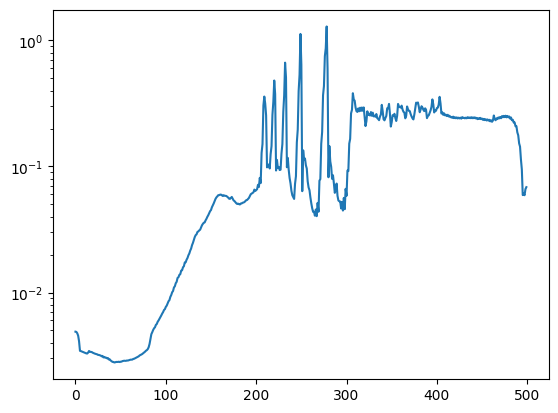

In [26]:
plt.yscale("log") 
plt.plot(relu_grads)

In [27]:
sum(relu_grads) / len(relu_grads)

0.1438513027378358

In [28]:
relu_loss_gaps

-1.0912302732467651

In [29]:
def calc_acc(mdl):
    score = 0
    for idx, tensor in enumerate(mdl(x)):
        res = tensor.argmax()
        if res == y[idx]:
            score +=1
    avg_score = score / len(x)
    return avg_score

In [30]:
calc_acc(sig_mdl)

0.3416666666666667

In [31]:
calc_acc(relu_mdl)

0.9916666666666667

(0.04203641414642334, 1.3640378415584564)

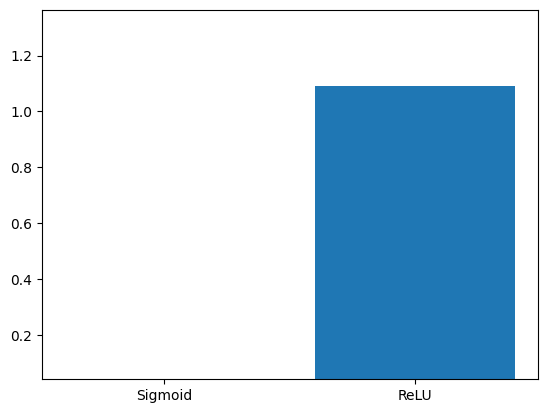

In [32]:
plt.bar(['Sigmoid', 'ReLU'], [-sig_loss_gaps, -relu_loss_gaps])
plt.ylim(-sig_loss_gaps, -relu_loss_gaps * 1.25)


# Mitigating Vanishing Gradients

### 1. Replace Sigmoid with ReLU
ReLU activations avoid saturation, keeping gradients larger.

### 2. Use Batch Normalization
Batch normalization normalizes activations, reducing gradient shrinkage.

### 3. Proper Weight Initialization
Techniques like Xavier Initialization or He Initialization help maintain gradient flow.

---



### Using Batch Normalization

Here, we add Batch Normalization to further stabilize gradients.


BatchNorm1d operates on 1 dimensional data, like the one coming out ouf a linear layer.

For example, if we have the data (16, 4) -> for 16 images with 4 features each, we calculate a 16 rows mean for every feature. We are going to get 4 means, one for every feature. 

If I have 2d data, like width and height for an image for example, I use BatchNorm2d, which takes every channel (red/green/blue) and for each channel it computes the average using both height and width treated equally. It will then take every pixel and normalize it using that value. In this case we get 3 means and 3 stds, one for each channel.

In [33]:
class DeepNetBatchNorm(nn.Module):
    def __init__(self):
        super(DeepNetBatchNorm, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )
    
    def forward(self, x):
        return self.layers(x)

In [34]:
x,y = return_data()

In [35]:
model = DeepNetBatchNorm()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [36]:
mdl, batch_norm_grads, _ = train_and_return_grads(model)

tensor(1.0538, grad_fn=<NllLossBackward0>)
tensor(0.0016, grad_fn=<NllLossBackward0>)
tensor(0.0006, grad_fn=<NllLossBackward0>)
tensor(0.0003, grad_fn=<NllLossBackward0>)
tensor(0.0002, grad_fn=<NllLossBackward0>)


In [37]:
batch_norm_grads

[0.3150328993797302,
 0.24069415032863617,
 0.16002337634563446,
 0.0964677482843399,
 0.0574646070599556,
 0.04031243547797203,
 0.044325366616249084,
 0.0458955243229866,
 0.04586837813258171,
 0.038557421416044235,
 0.036421485245227814,
 0.03717328608036041,
 0.03155295550823212,
 0.03346782177686691,
 0.03552224114537239,
 0.031776223331689835,
 0.029892848804593086,
 0.024186428636312485,
 0.023618489503860474,
 0.0362916998565197,
 0.036260511726140976,
 0.040997810661792755,
 0.036904167383909225,
 0.030248286202549934,
 0.022618599236011505,
 0.020282384008169174,
 0.019315287470817566,
 0.020166438072919846,
 0.02956308238208294,
 0.0367870032787323,
 0.031090978533029556,
 0.028348585590720177,
 0.02488640509545803,
 0.02860521711409092,
 0.030957769602537155,
 0.03147761896252632,
 0.028130194172263145,
 0.028468959033489227,
 0.033602796494960785,
 0.035801373422145844,
 0.027561020106077194,
 0.026859449222683907,
 0.026172230020165443,
 0.049101267009973526,
 0.044033572

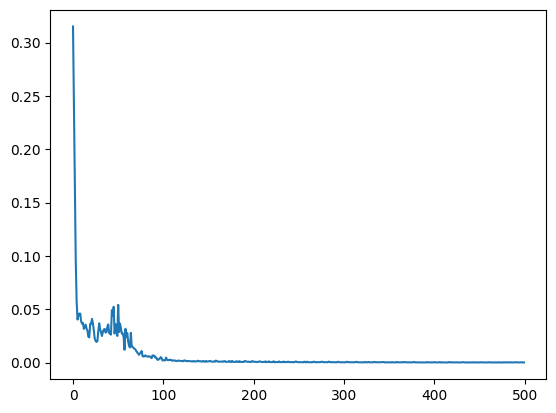

In [38]:
plt.plot(batch_norm_grads)

In [39]:
sum(batch_norm_grads) / len(batch_norm_grads)

0.006434015173435909

In [40]:
calc_acc(model)

1.0